Förklaring från Alexei om val av att ha json i snowflake:

Grejen är att metering_point och meter_reading data kan uppdateras i efterhand. T.ex. det finns c1-c5 koefficienterna som kan tillkomma, väderdata, standardavvikelse på mätningen, etc. Problemet är att detta kan hända rätt ofta i fortsättningen och update operationen är tidskrävande. Samtidigt kan datamodellen ändras, osannolikt men möjligt. Då skulle man behöva designa om tabellerna. Därför valde vi att lagra allt data som kommer istället och skapa endast de viktigaste kolumnerna som behövs för att skapa views. Du kan fortfarande köra queries mot json som om det vore SQL. Det är fördelen med snowflake - https://docs.snowflake.com/en/user-guide/querying-semistructured.html

Hämta all öresundskraft data för property=energi, formattera med rätt dataformat direkt i sql

In [89]:
import pyodbc

#Using connection string to connect to the datalake
connection = pyodbc.connect("Driver={SnowflakeDSIIDriver}; Server=lq42418.eu-west-1.snowflakecomputing.com; Database=SMARTENERGI_DATALAKE; schema=public; UID=smartenergi_public_user; PWD=SmartEnergi2020!")
cus=connection.cursor()

#Executing the query on meter readings view
cus.execute("use warehouse compute_wh;")
select_stmt = """WITH energy_by_day as
(SELECT date(SRC:timestamp::datetime) as timestamp, SRC:metering_point_id::string as metering_point_id, sum(SRC:value::integer) as value, SRC:unit_of_measure::string as unit_of_measure
FROM "SMARTENERGI_DATALAKE"."PUBLIC"."METER_READINGS" 
WHERE PROPERTY = 'energy' and SRC:source_instance_name like '%oresundskraft%'
group by date(SRC:timestamp::datetime), SRC:metering_point_id, SRC:unit_of_measure), 

 days_per_station as
(select metering_point_id, min(timestamp), max(timestamp), count(*) as N
from energy_by_day
group by metering_point_id
order by count(*) desc)

select e.* 
from energy_by_day e
inner join (select metering_point_id
from days_per_station
where N>=1638) m on e.metering_point_id = m.metering_point_id
"""
       
select_stmt2 = """WITH energy_by_day as
(SELECT date(SRC:timestamp::datetime) as timestamp, SRC:metering_point_id::string as metering_point_id, sum(SRC:value::integer) as value, SRC:unit_of_measure::string as unit_of_measure
FROM "SMARTENERGI_DATALAKE"."PUBLIC"."METER_READINGS" 
WHERE PROPERTY = 'energy' and SRC:source_instance_name like '%oresundskraft%'
group by date(SRC:timestamp::datetime), SRC:metering_point_id, SRC:unit_of_measure), 

 days_per_station as
(select metering_point_id, min(timestamp), max(timestamp), count(*) as N
from energy_by_day
group by metering_point_id
order by count(*) desc)

select metering_point_id
from days_per_station
where N>=1638
limit 100"""
cus.execute(select_stmt)


Hämta data

In [ ]:
data = cus.fetchall()

Hämta direkt som pandas data frame

In [90]:
import pandas as pd
df = pd.read_sql(select_stmt,connection)


In [91]:
df.head()

,TIMESTAMP,METERING_POINT_ID,VALUE,UNIT_OF_MEASURE
0,2015-08-25,5913b86c-7184-11ea-ae00-062fc13530dc,27.0,MWh
1,2015-09-11,5913b86c-7184-11ea-ae00-062fc13530dc,77.0,MWh
2,2015-09-19,5913b86c-7184-11ea-ae00-062fc13530dc,77.0,MWh
3,2015-10-02,5913b86c-7184-11ea-ae00-062fc13530dc,100.0,MWh
4,2015-08-30,5913b86c-7184-11ea-ae00-062fc13530dc,30.0,MWh


In [156]:
ids=df.METERING_POINT_ID.unique()

In [166]:
df['VALUE_NORM'] = df.groupby('METERING_POINT_ID')['VALUE'].apply(lambda x: (x-x.min())/(x.max()-x.min()))

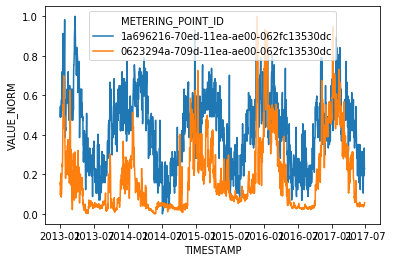

In [37]:
import seaborn as sns
import numpy as np

df_g1 = df[df['METERING_POINT_ID'].isin(ids[:2])]
sns.lineplot(x='TIMESTAMP', y='VALUE_NORM', hue='METERING_POINT_ID', data=df_g1)

In [92]:
df.shape

(3891888, 4)

In [201]:
 df_wide = df.pivot(index='TIMESTAMP',columns='METERING_POINT_ID', values = 'VALUE')

In [94]:
df_wide.shape

(1638, 2376)

In [61]:
#df_wide.iloc[:,1:10].transpose().values.tolist()

In [211]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

seed = 0
np.random.seed(seed)

X_train = TimeSeriesScalerMeanVariance().fit_transform(df_wide.transpose().values.tolist())


In [212]:
X_train_orig = X_train

In [96]:
X_train.shape

(2376, 1638, 1)

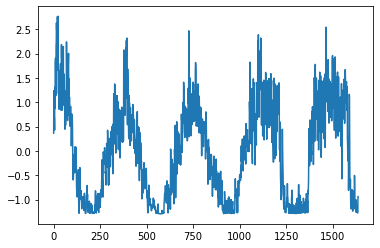

In [97]:
import matplotlib.pyplot as plt
plt.plot(X_train[0])

In [98]:
# Make time series shorter
X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
#X_train.shape
#plt.plot(X_train[0])
sz = X_train.shape[1]

In [107]:
np.isin(y_pred, [9,3])

array([False, False,  True, ..., False, False,  True])

Ta bort kluster 3,5,6,7

In [138]:
X_train_cleaned = X_train[~np.isin(y_pred, [2,4,5,6])]
X_train_cleaned.shape

(2282, 100, 1)

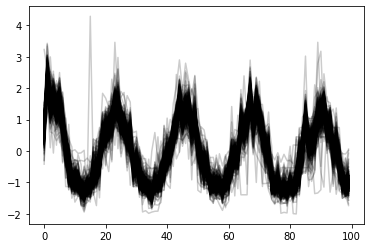

In [136]:
for xx in X_train[y_pred==1]:
        plt.plot(xx.ravel(), "k-", alpha=.2)

In [144]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([ 66, 868,  91, 312,   1,   1,   1, 101, 128, 807], dtype=int64))

Euclidean k-means
8.267 --> 6.660 --> 6.475 --> 6.409 --> 6.376 --> 6.359 --> 6.350 --> 6.343 --> 6.337 --> 6.332 --> 6.325 --> 6.320 --> 6.315 --> 6.311 --> 6.303 --> 6.297 --> 6.293 --> 6.285 --> 6.275 --> 6.272 --> 6.271 --> 6.270 --> 6.270 --> 6.269 --> 6.269 --> 6.268 --> 6.268 --> 6.268 --> 6.268 --> 6.268 --> 6.268 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 6.267 --> 


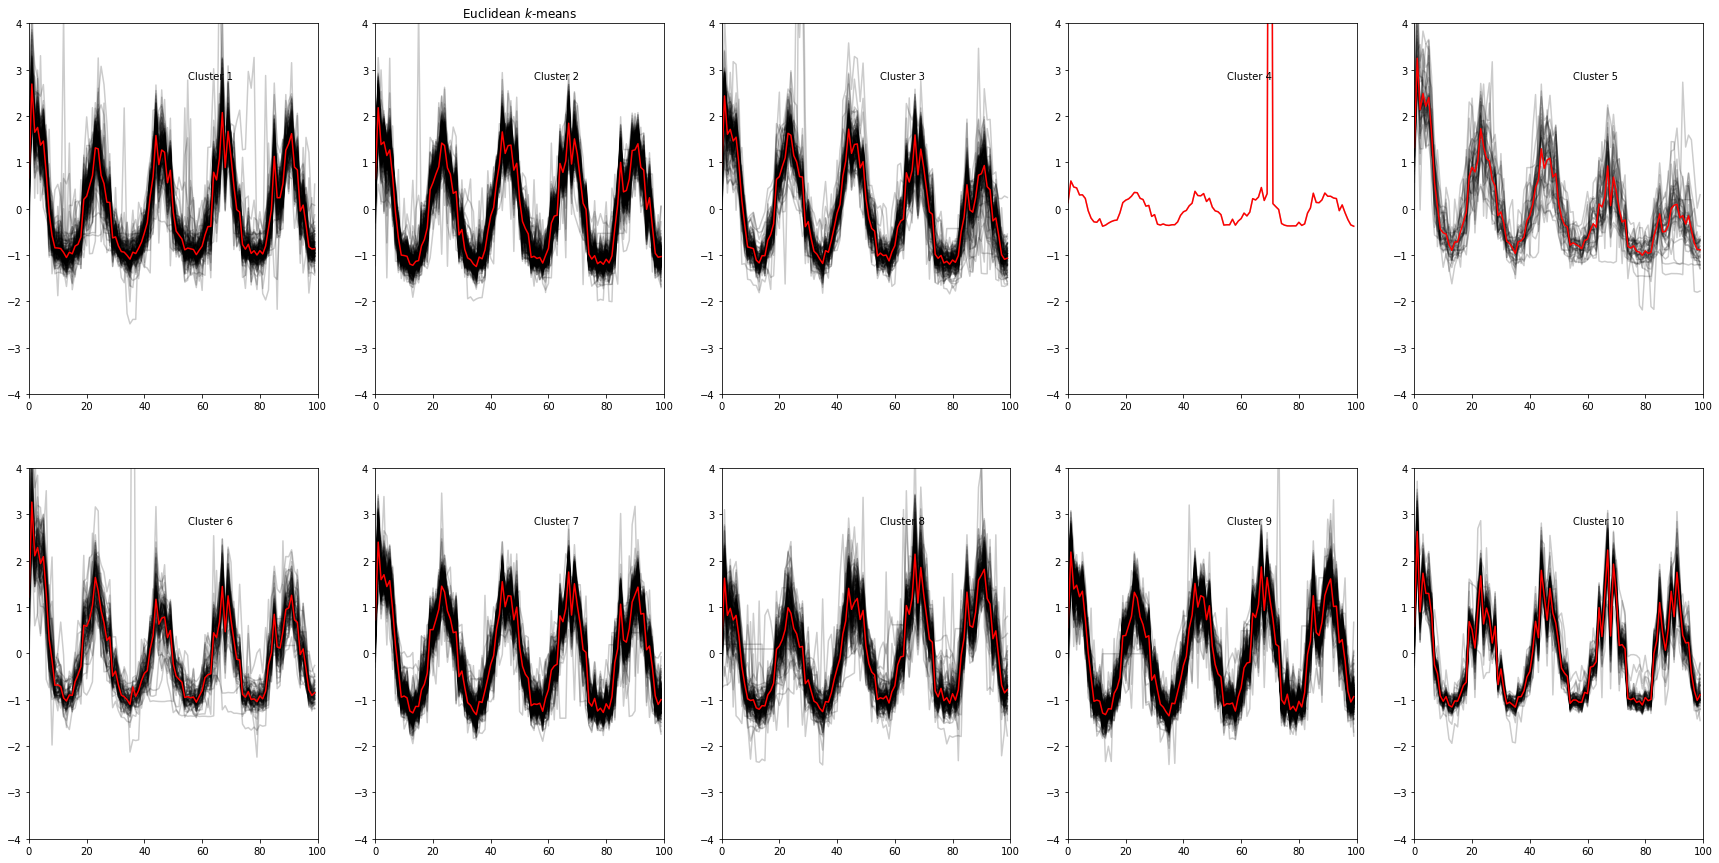

In [139]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=10, verbose=True, random_state=seed)
y_pred2 = km.fit_predict(X_train_cleaned)

plt.figure(figsize=(30,15))
for yi in range(10):
    plt.subplot(2, 5, yi + 1)
    for xx in X_train_cleaned[y_pred2 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [141]:
np.unique(y_pred2, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64),
 array([145, 438, 122,   1,  31,  66, 641, 118, 639,  81], dtype=int64))

(2184, 100, 1)
7.513 --> 6.294 --> 6.116 --> 6.054 --> 6.028 --> 6.019 --> 6.013 --> 6.008 --> 6.005 --> 6.002 --> 6.001 --> 6.000 --> 5.999 --> 5.999 --> 5.998 --> 5.998 --> 5.997 --> 5.997 --> 5.997 --> 5.997 --> 5.997 --> 


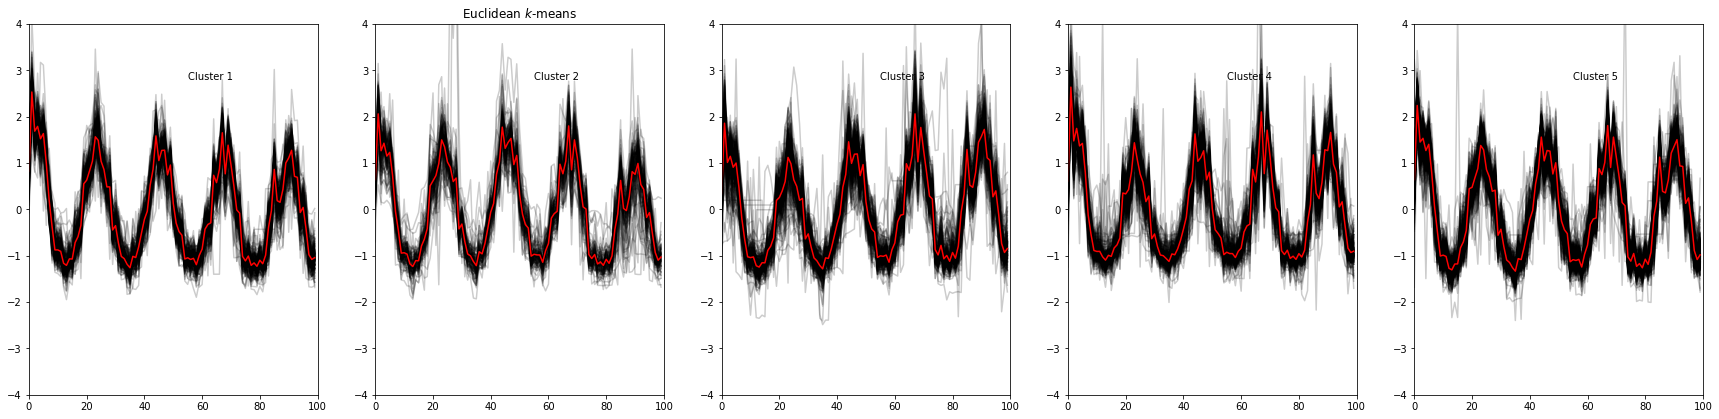

In [143]:
X_train_cleaned2 = X_train_cleaned[~np.isin(y_pred2, [3, 4, 5])]
print(X_train_cleaned2.shape)
km = TimeSeriesKMeans(n_clusters=5, verbose=True, random_state=seed)
y_pred3 = km.fit_predict(X_train_cleaned2)

plt.figure(figsize=(30,15))
for yi in range(5):
    plt.subplot(2, 5, yi + 1)
    for xx in X_train_cleaned2[y_pred3 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

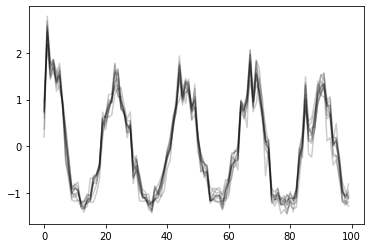

In [152]:
group2=X_train[y_pred==1]
for xx in group2[20:30]:
        plt.plot(xx.ravel(), "k-", alpha=.2)

Tillbaka till ursprunglig data, vilka mätstationer motsvarar ovanstående val från grupp 2?

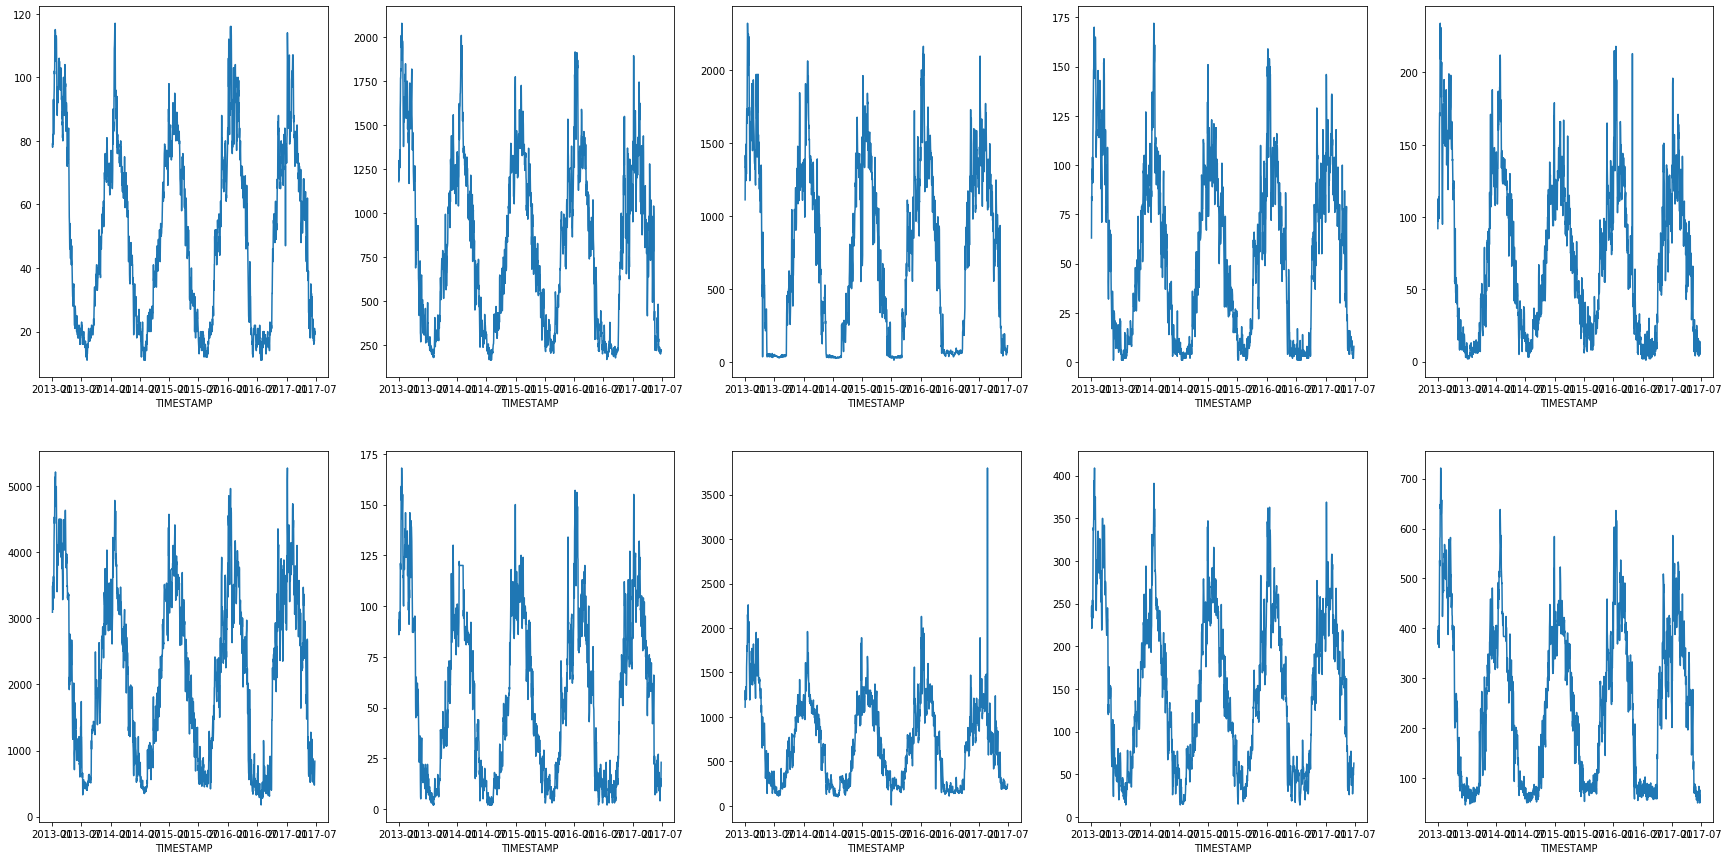

In [221]:
df_selected = df_wide.loc[:,list(y_pred==1)].iloc[:, 20:30]
plt.figure(figsize=(30,15))
for i in range(10):
    plt.subplot(2, 5, i+1)
    o=df_selected[df_selected.columns[i]]
    #o_norm = (o-o.min())/(o.max()-o.min())
    o.plot()

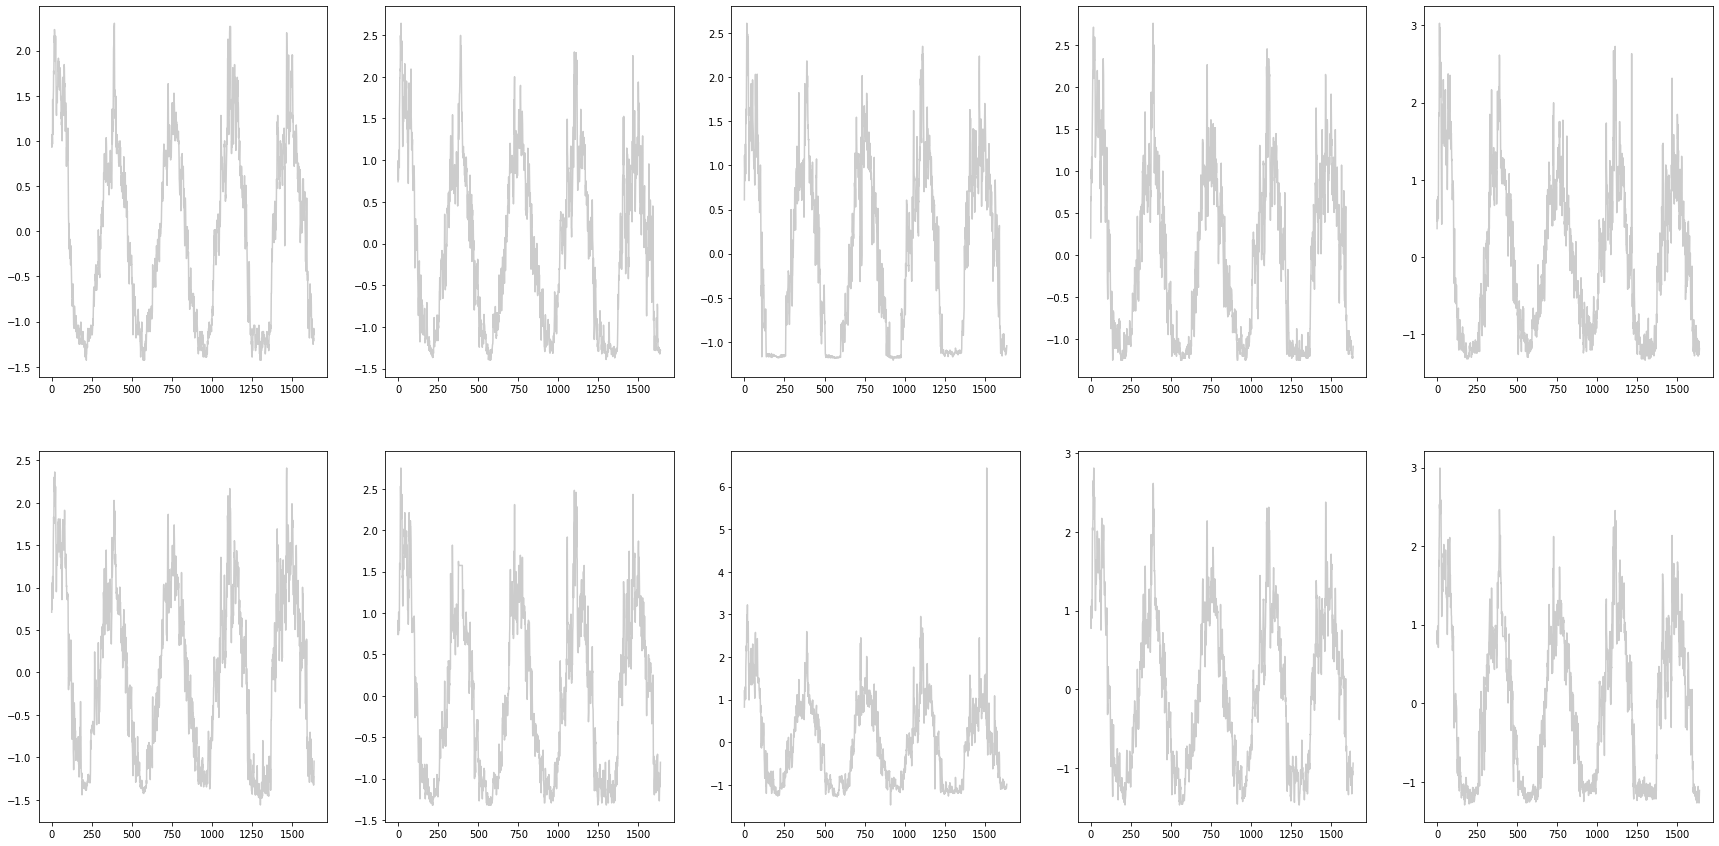

In [217]:
plt.figure(figsize=(30,15))
for i,xx in enumerate(X_train_orig[y_pred==1][20:30]):
    plt.subplot(2, 5, i+1)
    plt.plot(xx.ravel(), "k-", alpha=.2)

## Testa forecasting

In [281]:
def prepare_for_prophet(df):
    df = df.reset_index()
    df.columns = ['ds', 'y']
    df['ds'] = pd.to_datetime(df['ds'])
    return df

#validation: 2016-06-27 tom 2017-06-26
def divide_into_train_and_test(df):
    train = df[df.ds <= '2015-06-27']
    test = df[(df.ds > '2015-06-27') & (df.ds<='2016-06-26')]
    return train, test

def mean_absolute_percentage_error(y_pred, y_true):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

from sklearn.metrics import mean_squared_error

def print_errors(y_pred, y_true):
    print('MAPE: ', round(mean_absolute_percentage_error(y_pred, y_true), 2), '\nRMSE: ', round(mean_squared_error(y_pred, y_true, squared=False), 2))

In [232]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [363]:
df = prepare_for_prophet(df_selected[df_selected.columns[0]])
train, test = divide_into_train_and_test(df)

In [276]:
m = Prophet(weekly_seasonality=False)
m.fit(train)

future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


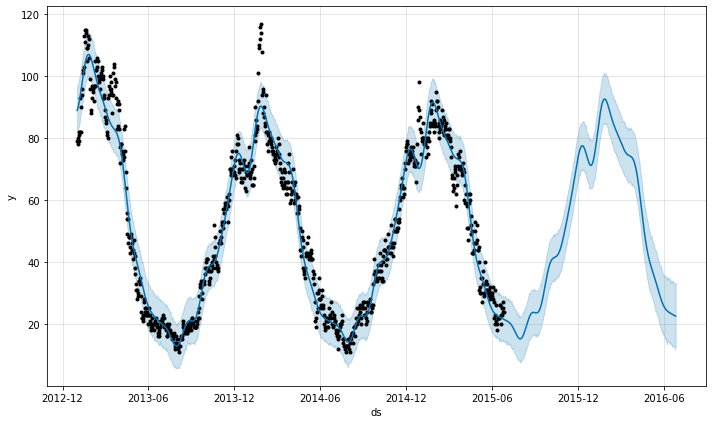

In [277]:
fig = m.plot(forecast)

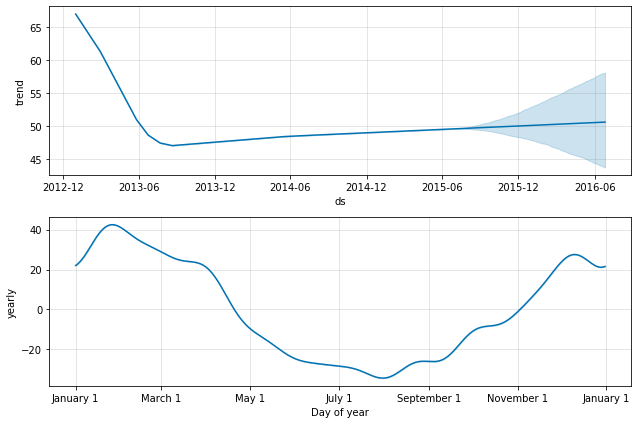

In [278]:
fig = m.plot_components(forecast)

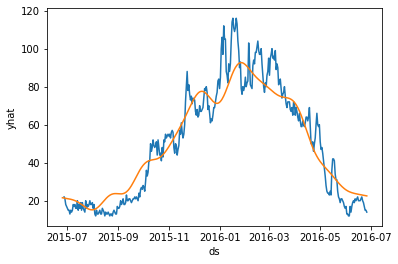

In [279]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])

In [282]:
print_errors(forecast.yhat[-365:], test.y)

MAPE:  21.33 
RMSE:  9.65


Läs in lufttemperatur för Helsingborg

In [319]:
temp = pd.read_csv('data/HelsingborgA_lufttemperatur_dygn.csv', skiprows=9, sep=';')
temp['Representativt dygn'] = pd.to_datetime(temp['Representativt dygn'])
temp.head()

,Från Datum Tid (UTC),Till Datum Tid (UTC),Representativt dygn,Lufttemperatur,Kvalitet,Unnamed: 5,Tidsutsnitt:
0,1995-08-01 00:00:01,1995-08-02 00:00:00,1995-08-01,20.8,Y,NaN,Kvalitetskontrollerade historiska data (utom d...
1,1995-08-02 00:00:01,1995-08-03 00:00:00,1995-08-02,21.4,Y,NaN,Tidsperiod (fr.o.m.) = 1995-08-01 00:00:00 (UTC)
2,1995-08-03 00:00:01,1995-08-04 00:00:00,1995-08-03,20.2,Y,NaN,Tidsperiod (t.o.m.) = 2020-03-01 06:00:00 (UTC)
3,1995-08-04 00:00:01,1995-08-05 00:00:00,1995-08-04,20.7,Y,NaN,Medelvärdet är beräknat för = 24 timmar
4,1995-08-05 00:00:01,1995-08-06 00:00:00,1995-08-05,20.3,Y,NaN,NaN


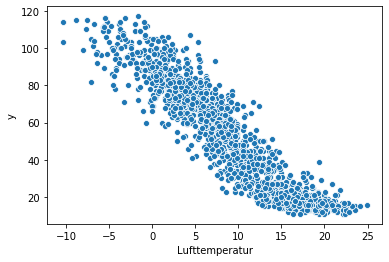

In [364]:
df_temp = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp)

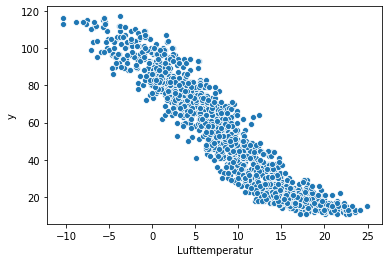

In [365]:
df['ds-1'] = df['ds'] - pd.DateOffset(days=1)
df['ds+1'] = df['ds'] + pd.DateOffset(days=1)

df_temp_minus1 = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds-1', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp_minus1)

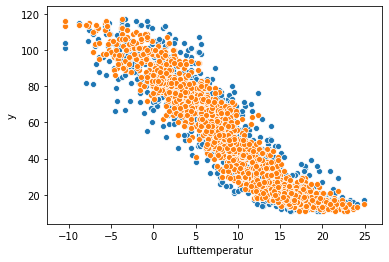

In [366]:
df_temp_plus1 = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds+1', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp_plus1)
sns.scatterplot(x='Lufttemperatur', y='y', data=df_temp_minus1)

In [323]:
print(df_temp['y'].corr(df_temp['Lufttemperatur']), df_temp_minus1['y'].corr(df_temp_minus1['Lufttemperatur']), df_temp_plus1['y'].corr(df_temp_plus1['Lufttemperatur']))

-0.9492514499284984 -0.9539156352495307 -0.9306440922249924


Att skifta energikonsumtion 1 dag framåt ger högst korrelation med lufttemperatur från Helsingborg A mätstation

## Testa Prophet med extra regressor temperatur

In [324]:
temp['Representativt dygn'] = temp['Representativt dygn'] - pd.DateOffset(days=1)
temp['Temp_K'] = temp.Lufttemperatur+273.15
temp['Temp_K_norm'] = (temp.Temp_K-temp.Temp_K)/((15+273.15)-temp.Temp_K.min()).clip(1.)

In [330]:
df_temp = df.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left')

train, test = divide_into_train_and_test(df_temp)

m_temp = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True,
            ).add_regressor('Lufttemperatur', prior_scale=100, mode = 'multiplicative')

m_temp.fit(train)

future_temp = m_temp.make_future_dataframe(periods=365)
future_temp['Lufttemperatur'] = df_temp['Lufttemperatur']

forecast_temp = m_temp.predict(future_temp)

print_errors(forecast_temp.yhat[-365:], test.y)

MAPE:  15.74 
RMSE:  9.06


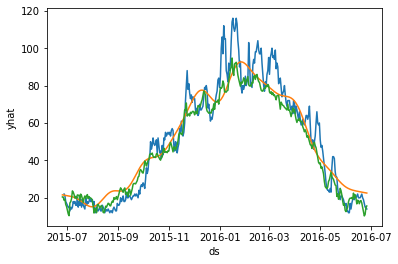

In [331]:
sns.lineplot(x = 'ds', y = 'y', data=test)
sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])
sns.lineplot(x = 'ds', y = 'yhat', data=forecast_temp[forecast_temp.ds>='2015-06-26'])

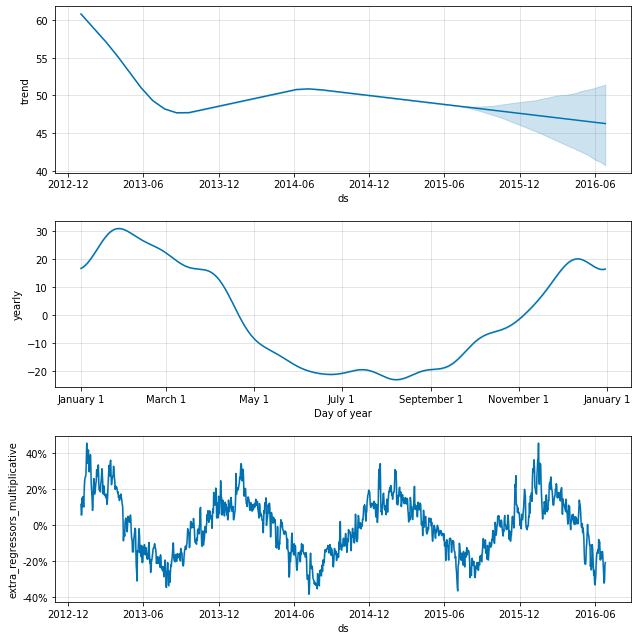

In [327]:
fig = m_temp.plot_components(forecast_temp)

Problemet med låg förklaringsgrad med hjälp av temperatur beror på hög variation per temperatur för konsumtion alt. lägre korrelation temperatur/konsumtion än för TDS9

In [333]:
df_selected

METERING_POINT_ID,05af2fa8-71c0-11ea-ae00-062fc13530dc,066e8dc0-7086-11ea-ae00-062fc13530dc,06e30e72-70ac-11ea-ae00-062fc13530dc,070bfee4-7143-11ea-ae00-062fc13530dc,0710e7ea-71a9-11ea-ae00-062fc13530dc,076ee926-7091-11ea-ae00-062fc13530dc,08a63cbc-71d2-11ea-ae00-062fc13530dc,09051334-70a3-11ea-ae00-062fc13530dc,09206288-729c-11ea-ae02-062fc13530dc,0965436e-7033-11ea-ae00-062fc13530dc
TIMESTAMP,,,,,,,,,,
2013-01-01,79.0,1180.0,1110.0,63.0,92.0,3090.0,86.0,1110.0,235.0,369.0
2013-01-02,78.0,1300.0,1415.0,84.0,112.0,3490.0,93.0,1300.0,247.0,396.0
2013-01-03,80.0,1190.0,1332.0,82.0,97.0,3130.0,86.0,1190.0,221.0,387.0
2013-01-04,82.0,1250.0,1336.0,96.0,98.0,3160.0,87.0,1190.0,230.0,370.0
2013-01-05,81.0,1290.0,1281.0,98.0,113.0,3540.0,97.0,1320.0,245.0,405.0
...,...,...,...,...,...,...,...,...,...,...
2017-06-22,18.0,201.0,79.0,3.0,6.0,614.0,15.0,213.0,54.0,67.0
2017-06-23,17.0,218.0,62.0,2.0,14.0,477.0,11.0,194.0,49.0,51.0
2017-06-24,21.0,214.0,74.0,5.0,5.0,624.0,11.0,200.0,56.0,52.0


In [367]:
temp['Interval'] = pd.cut(temp['Lufttemperatur'], [-100, 2, 9, 15, 100])

df_test = df.merge(temp[['Representativt dygn', 'Lufttemperatur', 'Interval']], left_on='ds', right_on='Representativt dygn', how='left')
df_test['mean_y'] = df_test.groupby('Interval')['y'].transform('mean')
df_test['res_mean'] = df_test['y'] - df_test['mean_y']
df_test.res_mean.std()

11.98140922249406

In [345]:
df_test

,ds,y,ds-1,ds+1,Representativt dygn,Lufttemperatur,Interval,mean_y,res_mean
0,2013-01-01,79.0,2012-12-31,2013-01-02,2013-01-01,3.9,"(2, 9]",67.154499,11.845501
1,2013-01-02,78.0,2013-01-01,2013-01-03,2013-01-02,6.4,"(2, 9]",67.154499,10.845501
2,2013-01-03,80.0,2013-01-02,2013-01-04,2013-01-03,6.0,"(2, 9]",67.154499,12.845501
3,2013-01-04,82.0,2013-01-03,2013-01-05,2013-01-04,2.4,"(2, 9]",67.154499,14.845501
4,2013-01-05,81.0,2013-01-04,2013-01-06,2013-01-05,4.4,"(2, 9]",67.154499,13.845501
...,...,...,...,...,...,...,...,...,...
1633,2017-06-22,18.0,2017-06-21,2017-06-23,2017-06-22,16.6,"(15, 100]",18.582447,-0.582447
1634,2017-06-23,17.0,2017-06-22,2017-06-24,2017-06-23,15.5,"(15, 100]",18.582447,-1.582447
1635,2017-06-24,21.0,2017-06-23,2017-06-25,2017-06-24,15.3,"(15, 100]",18.582447,2.417553
1636,2017-06-25,19.0,2017-06-24,2017-06-26,2017-06-25,14.4,"(9, 15]",33.936430,-14.936430


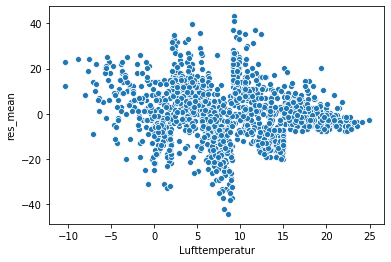

In [368]:
sns.scatterplot(x='Lufttemperatur', y='res_mean', data=df_test)

In [369]:
from backend.Matrix import Matrix
from backend.Group import Group
from backend.Point import Point
#from standard_deviation import StandardDeviation #Kopierad från källkoden, går ej att importera

#temperaturintervall, hårdkodat i _default_controller.py
BREAKPOINTS = [-5, 2, 9, 15, 20]

def fill_points_with_data(df):
    points = []
    for index, row in df.iterrows():
        point = Point()
        point.temp = float(row['Lufttemperatur'])
        try:
            point.reading = row['y'] 
            point.timestamp = row['ds']
            point.consumption_timestamp = row['ds']
            point.breakpoints = BREAKPOINTS
        except:
            None
        points.append(point)
    return points

points_energy = fill_points_with_data(df_test)

g_energy = Group()
g_energy.set_breakpoints(BREAKPOINTS)
g_energy.set_points(points_energy)

koff = g_energy.calcKoff()
g_energy.updatePointRegression(koff)

df_test['Regression'] = [point.regression for point in g_energy.points]
df_test['res_reg'] = df_test['y'] - df_test['Regression'] 


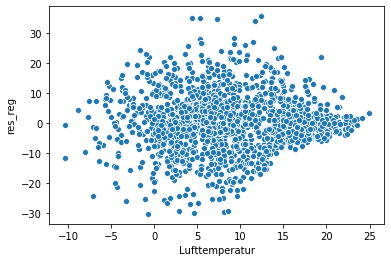

In [370]:


sns.scatterplot(x='Lufttemperatur', y='res_reg', data=df_test)

In [371]:
df_test.res_reg.std()

9.371673886332426

In [381]:
stds = []
df_group2 = df_wide.loc[:,list(y_pred==1)]

for i in range(df_group2.shape[1]):
    if i%100==0:
        print(i)
    df_temp = prepare_for_prophet(df_group2[df_group2.columns[i]])
    df_test_temp = df_temp.merge(temp[['Representativt dygn', 'Lufttemperatur', 'Interval']], left_on='ds', right_on='Representativt dygn', how='left')
    points_energy = fill_points_with_data(df_test_temp)

    g_energy = Group()
    g_energy.set_breakpoints(BREAKPOINTS)
    g_energy.set_points(points_energy)
    
    koff = g_energy.calcKoff()
    g_energy.updatePointRegression(koff)
    
    df_test_temp['Regression'] = [point.regression for point in g_energy.points]
    df_test_temp['res_reg'] = df_test_temp['y'] - df_test_temp['Regression'] 
    stds.append(df_test_temp['res_reg'].std())

0
100
200
300
400
500
600
700
800


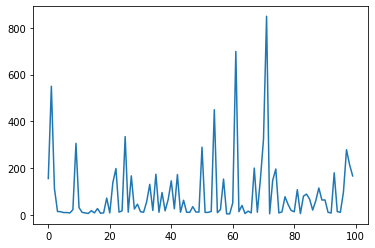

In [361]:
plt.plot(np.linspace(0,99,100), stds)

In [395]:
lowest_std = np.argsort(stds)
lowest_std[:10]

array([171, 523,  59, 446,  58,  72, 622, 699, 831, 260], dtype=int64)

In [383]:
stds[171]

4.7645370120842205

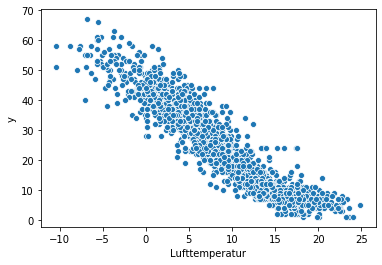

In [384]:
df_temp = prepare_for_prophet(df_group2[df_group2.columns[171]])
df_test_temp = df_temp.merge(temp[['Representativt dygn', 'Lufttemperatur', 'Interval']], left_on='ds', right_on='Representativt dygn', how='left')
sns.scatterplot(x='Lufttemperatur', y='y', data=df_test_temp)

Även anläggningen med lägst standardavvikelse har en ful temperaturkurva :(

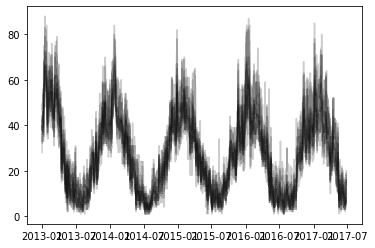

In [394]:
df_selected2 = df_group2.iloc[:, lowest_std[:10]]
for i in range(10):
    xx = df_selected2[df_selected2.columns[i]]
    plt.plot(xx, "k-", alpha=.2)

In [398]:
def train_prophet(df, regressor_list = None):
    train, test = divide_into_train_and_test(df)

    m = Prophet(growth = 'linear', 
             weekly_seasonality = False,
             daily_seasonality = False,
             yearly_seasonality = True)
    
    if regressor_list:
        for r in regressor_list:
            m.add_regressor(r, prior_scale=1, mode = 'multiplicative')
    
    m.fit(train)
    future= m.make_future_dataframe(periods=365)
    
    if regressor_list:
        for r in regressor_list:
            future[r] = df[r]
    
    forecast = m.predict(future)    
    return forecast, future, m

MAPE:  44.79 
RMSE:  7.22
MAPE:  66.87 
RMSE:  9.01
MAPE:  76.01 
RMSE:  11.85
MAPE:  35.15 
RMSE:  7.22
MAPE:  44.15 
RMSE:  11.18
MAPE:  85.61 
RMSE:  13.96
MAPE:  56.47 
RMSE:  8.23
MAPE:  45.72 
RMSE:  10.98
MAPE:  70.26 
RMSE:  11.84
MAPE:  39.04 
RMSE:  8.98


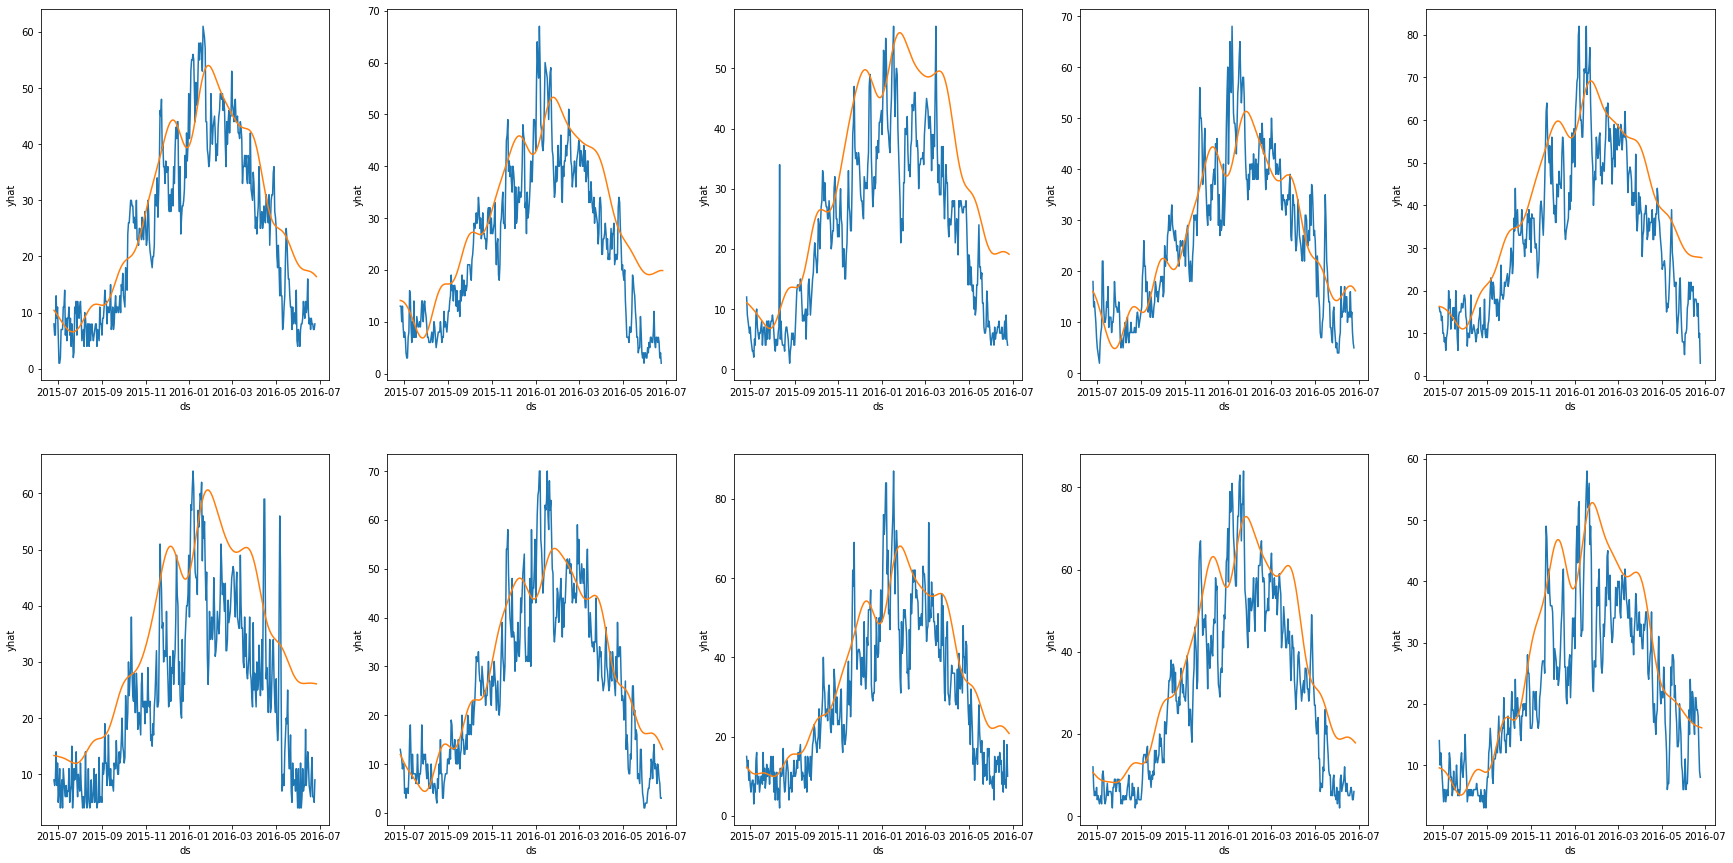

In [409]:
results = pd.DataFrame()
mape = []
rmsd = []
plt.figure(figsize=(30,15))
for i in range(10):
    df_t = prepare_for_prophet(df_selected2[df_selected2.columns[i]])
    df_merged = df_t.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left')
    forecast, future, m = train_prophet(df_merged)
    test=df_merged[(df_merged.ds>='2015-06-26') & (df_merged.ds < '2016-06-25')]
    mape.append(round(mean_absolute_percentage_error(forecast.yhat[-365:], test.y), 2))
    rmsd.append(round(mean_squared_error(forecast.yhat[-365:], test.y, squared=False), 2))
    print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(2,5,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])
    
results['rmsd'] = rmsd
results['mape'] = mape

MAPE:  26.72 
RMSE:  5.01
MAPE:  34.62 
RMSE:  5.58
MAPE:  38.62 
RMSE:  7.14
MAPE:  24.57 
RMSE:  5.95
MAPE:  22.09 
RMSE:  6.76
MAPE:  55.16 
RMSE:  11.31
MAPE:  35.76 
RMSE:  6.59
MAPE:  31.4 
RMSE:  8.17
MAPE:  43.21 
RMSE:  8.28
MAPE:  31.52 
RMSE:  7.19


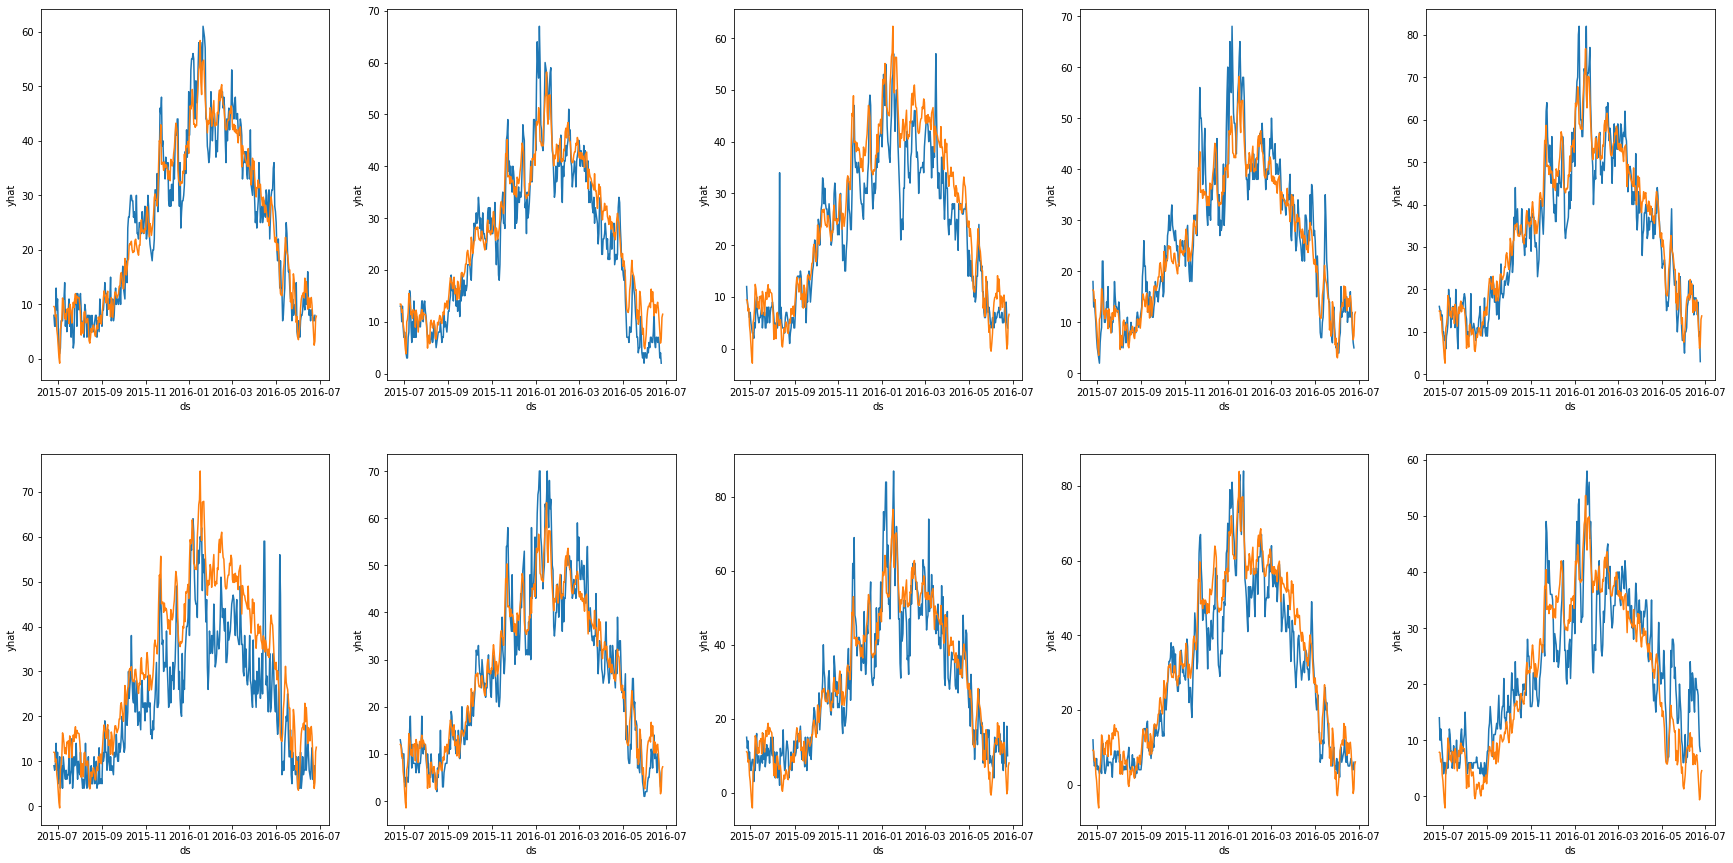

In [410]:

mape = []
rmsd = []

plt.figure(figsize=(30,15))
for i in range(10):
    df_t = prepare_for_prophet(df_selected2[df_selected2.columns[i]])
    df_merged = df_t.merge(temp[['Representativt dygn', 'Lufttemperatur']], left_on='ds', right_on='Representativt dygn', how='left')
    forecast, future, m = train_prophet(df_merged, regressor_list=['Lufttemperatur'])
    test=df_merged[(df_merged.ds>='2015-06-26') & (df_merged.ds < '2016-06-25')]
    mape.append(round(mean_absolute_percentage_error(forecast.yhat[-365:], test.y), 2))
    rmsd.append(round(mean_squared_error(forecast.yhat[-365:], test.y, squared=False), 2))
    print_errors(forecast.yhat[-365:], test.y)
    plt.subplot(2,5,i+1)
    sns.lineplot(x = 'ds', y = 'y', data=test)
    sns.lineplot(x = 'ds', y = 'yhat', data=forecast[forecast.ds>='2015-06-26'])
    
results['rmsd_temp'] = rmsd
results['mape_temp'] = mape

In [411]:
results

,rmsd,mape,rmsd_temp,mape_temp
0,7.22,44.79,5.01,26.72
1,9.01,66.87,5.58,34.62
2,11.85,76.01,7.14,38.62
3,7.22,35.15,5.95,24.57
4,11.18,44.15,6.76,22.09
5,13.96,85.61,11.31,55.16
6,8.23,56.47,6.59,35.76
7,10.98,45.72,8.17,31.40
8,11.84,70.26,8.28,43.21
9,8.98,39.04,7.19,31.52


Kan nog funka...

För tävling skall givet data vara 10 csv filer (exkluderat validerings period) som innehåller
Datum, konsumtion, temperatur och övriga vädervariabler för Helsingborg A som jag hittar, K2 regressionsresultat

